In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import re
import astropy.units as u

from tqdm import tqdm_notebook as tqdm
from scipy import signal

from scipy.stats import linregress

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f



In [3]:
def extract_t_A2A0(fourier, idx):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        A2r = fourier[key]['A2r'][idx]
        A2i = fourier[key]['A2i'][idx]
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
        A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_max_A2A0(fourier, debug=False):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = np.array(fourier[key]['A0'])
        A2r = np.array(fourier[key]['A2r'])
        A2i = np.array(fourier[key]['A2i'])
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
#         A2A0 = A2/A0
        A2A0list.append(np.max(A2/A0))
        if debug:
            print(tlist[i], fourier[key]['Rlist'][np.argmax(A2/A0)], np.max(A2/A0))
#         A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_AmA0(fourier, idx, m):

    i = 0

    tlist = np.array(fourier['time'])
    AmA0list = []
#     print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        Amr = fourier[key]['A'+str(m)+'r'][idx]
        Ami = fourier[key]['A'+str(m)+'i'][idx]
    
        Am = np.sqrt(Amr*Amr + Ami*Ami)
        AmA0list.append(Am/A0)
        i += 1
    
    return np.array(tlist), np.array(AmA0list)

In [4]:
def get_bar_angle(phi, firstkey):
    out = np.zeros(len(phi))

    # set the first bar angle
    first_bar_angle = phi[firstkey]/2.0
    out[firstkey] = first_bar_angle
    
    # set all subsequent angles
    for i in np.arange(firstkey+1, len(out)):
        dphi = phi[i] - phi[i-1]
        if dphi < -np.pi:
            dphi += 2.*np.pi
        out[i] = out[i-1] + dphi/2.0

    # set all previous angles to be the bar angle
    for i in np.arange(0, firstkey):
        out[i] = first_bar_angle

    return out

def get_sorted_keys(dat):
    keys = list(dat.keys())
    # only keep keys that are snapshot keys
    keys = [k for k in keys if 'snapshot' in k]

    # extract and sort indices
    indices = [int(re.findall(r'\d?\d?\d\d\d', k)[0]) for k in keys]
    sorted_arg = np.argsort(indices)
    keys_sorted = [keys[i] for i in sorted_arg]

    return keys_sorted

def get_A2_angle(dat, keys, Rbin, cum=False):
    if cum:
        rk = 'A2r_c'
        ri = 'A2i_c'
    else:
        rk = 'A2r'
        ri = 'A2i'
    
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])
    A2r = np.array([np.array(dat[k][rk]) for k in keys])
    A2i = np.array([np.array(dat[k][ri]) for k in keys])
    phi = np.arctan2(A2i, A2r)
    phi = phi[:,Rbin]
    R_at_Rbin = Rlist[:,Rbin]
    
    time = np.array(dat['time'])

    return time, R_at_Rbin, phi

def get_bar_length(dat, keys, Rmin=2, Rmax=10, ratio_cut = 2):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])

    A0 = np.array([np.array(dat[k]['A0']) for k in keys])
    A1r = np.array([np.array(dat[k]['A1r']) for k in keys])
    A1i = np.array([np.array(dat[k]['A1i']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    A3r = np.array([np.array(dat[k]['A3r']) for k in keys])
    A3i = np.array([np.array(dat[k]['A3i']) for k in keys])
    A4r = np.array([np.array(dat[k]['A4r']) for k in keys])
    A4i = np.array([np.array(dat[k]['A4i']) for k in keys])
    A5r = np.array([np.array(dat[k]['A5r']) for k in keys])
    A5i = np.array([np.array(dat[k]['A5i']) for k in keys])
    A6r = np.array([np.array(dat[k]['A6r']) for k in keys])
    A6i = np.array([np.array(dat[k]['A6i']) for k in keys])
    
    I0 = A0/2.
    I1 = np.sqrt(A1r*A1r + A1i*A1i)
    I2 = np.sqrt(A2r*A2r + A2i*A2i)
    I3 = np.sqrt(A3r*A3r + A3i*A3i)
    I4 = np.sqrt(A4r*A4r + A4i*A4i)
    I5 = np.sqrt(A5r*A5r + A5i*A5i)
    I6 = np.sqrt(A6r*A6r + A6i*A6i)
    
    Ib = I0 + I2 + I4 + I6
    Iib = I0 - I2 + I4 - I6
    
    IbIib = Ib/Iib
    
    Rbar_list = []
    for i,k in enumerate(keys):
        R = Rlist[i,:]
        ratio = IbIib[i,:]
        
        Rkey = np.logical_and(R > Rmin, R< Rmax)
        ratio = ratio[Rkey]
        R = R[Rkey]
        j = 0
        try:
            while ratio[j] > ratio_cut:
                j += 1
            Rbar = R[j-1] + (ratio_cut - ratio[j-1]) * (R[j]-R[j-1])/(ratio[j]-ratio[j-1])
        except:
            Rbar = np.nan
        Rbar_list.append(Rbar)

    time = np.array(dat['time'])    
    
    return time, np.array(Rbar_list)

def evaluate_polynomial(pfit, n, time, bar_angle_firstkey, firstkey):
    pfit_n = pfit[n]
    poly_bar_angle = np.zeros(len(time))
    poly_pattern_speed = np.zeros(len(time))

    for i in range(n+1):
        ba = pfit_n[i] * time ** (n-i)
        poly_bar_angle[firstkey:] += ba[firstkey:]
        ps = (n-i) * pfit_n[i] * time**(n-1-i)
        poly_pattern_speed[firstkey:] += ps[firstkey:]

    poly_bar_angle[:firstkey] += bar_angle_firstkey

    poly_pattern_speed = poly_pattern_speed / u.Myr
    poly_pattern_speed = poly_pattern_speed.to_value(u.km/u.s/u.kpc)

    return poly_bar_angle, poly_pattern_speed

def main_bar_angle(dat, Rbin = 3, firstkey = 150, nmax = 10, cum=False):
    # try loading snapshot
#     dat = h5.File(fname, mode='r')
    out = {}

    keys = get_sorted_keys(dat)
    time, R, phi = get_A2_angle(dat, keys, Rbin, cum=cum)
    time, Rbar = get_bar_length(dat, keys)
#     Rlist, Iibar = get_bar_length(dat, keys)
    bar_angle = get_bar_angle(phi, firstkey)

    pattern_speed = np.gradient(bar_angle, time) / u.Myr
    pattern_speed = pattern_speed.to_value(u.km/u.s/u.kpc)

    pfit = [np.polyfit(time[firstkey:], bar_angle[firstkey:], i) for i in range(nmax)]
    
    out['time'] = time
    out['firstkey'] = firstkey
    out['R'] = R
    out['Rbar'] = Rbar
    out['phi'] = phi
    out['bar_angle'] = bar_angle
    out['pattern_speed'] = pattern_speed
    out['pfit'] = pfit

    # now evaluate the polynomial for each fit and save the result
    out['poly_eval'] = {}
    for n in range(nmax):
        poly_bar_angle, poly_pattern_speed = evaluate_polynomial(pfit, n, time, bar_angle[firstkey], firstkey)

        out['poly_eval'][n] = (poly_bar_angle, poly_pattern_speed)

    return out
#     return Rlist, Iibar

In [5]:
fourierS_l3 = read_fourier(1, lvl='lvl3')
outS_l3 = main_bar_angle(fourierS_l3, Rbin=3, firstkey=0, cum=True)

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in reciprocal
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply


In [6]:
fourierS_l3['snapshot_000']['Rlist'][6]

3.245314172671956

In [7]:
fourierS_l3['time'][:]

array([0.00000000e+00, 5.25181781e+00, 1.00261976e+01, ...,
       7.81279514e+03, 7.81756952e+03, 7.82234390e+03])

In [8]:
idx_list = np.arange(300, 1250)
bar_angle = outS_l3['bar_angle'][idx_list]
time = outS_l3['time'][idx_list]
ps = outS_l3['pattern_speed'][idx_list]
# t, A2 = extract_t_max_A2A0(fourierS_l3)
A2_time, A2 = extract_t_A2A0(fourierS_l3, 7)

# time -= time[0]
# bar_angle -= bar_angle[0]

3.7442876763825113


In [9]:
reg = linregress(time, bar_angle)
m = reg.slope
b = reg.intercept
# m = (bar_angle[-1] - bar_angle[0]) / (time[-1] - time[0])
# b = bar_angle[0]

lin_ba = m * time + b

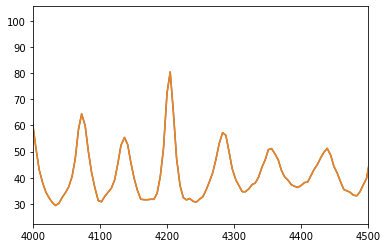

In [13]:
plt.plot(time, ps)
plt.xlim(4000, 4500)
plt.show()

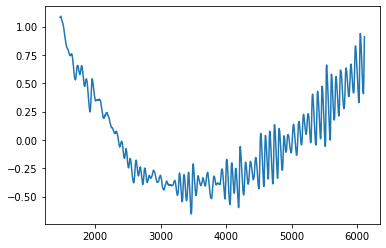

In [11]:
plt.plot(time, bar_angle - lin_ba)
# plt.plot(time-25, (tz_gas/800 - np.mean(tz_gas/800)))
# plt.plot(time-25, (tz_halo/800 - np.mean(tz_halo/800)))
plt.show()

In [14]:
# now read the torque on the gas
# idx_list = np.arange(100, 440)

torque_path = '/n/home01/abeane/starbar/plots/torques/data'
gas_base = torque_path + '/torques_phantom-vacuum-Sg20-Rc3.5-lvl3/torques_phantom-vacuum-Sg20-Rc3.5-lvl3.'

tz_halo = []
tz_not_bar = []
tz_gas = []

for idx in tqdm(idx_list):
    fname = gas_base + str(idx) + '.hdf5'
    
    t = h5.File(fname, mode='r')
    
    torque_halo = t['total_torques'].attrs['halo']
    tz_halo.append(torque_halo[2])
    
    torque_not_bar = t['total_torques'].attrs['not_bar']
    tz_not_bar.append(torque_not_bar[2])
    
    torque_gas = t['total_torques'].attrs['gas']
    tz_gas.append(torque_gas[2])
    
    
    t.close()

tz_halo = np.array(tz_halo)
tz_not_bar = np.array(tz_not_bar)
tz_gas = np.array(tz_gas)

A Jupyter Widget

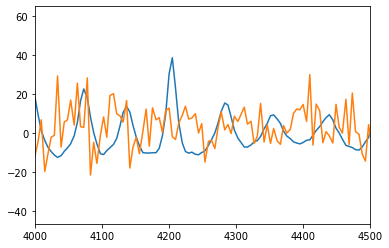

In [19]:
plt.plot(time, (ps - np.mean(ps)))
plt.plot(time, 3.*(tz_gas - np.mean(tz_gas)))
plt.xlim(4000, 4500)
# plt.plot(time-25, (tz_halo/800 - np.mean(tz_halo/800)))
plt.show()

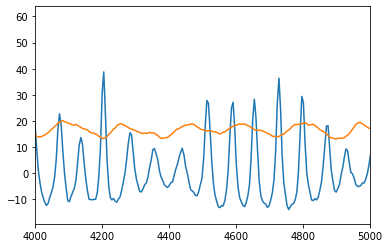

In [26]:
plt.plot(time, (ps - np.mean(ps)))
plt.plot(A2_time, 100.*A2)
plt.xlim(4000, 5000)
# plt.plot(time-25, (tz_halo/800 - np.mean(tz_halo/800)))
plt.show()

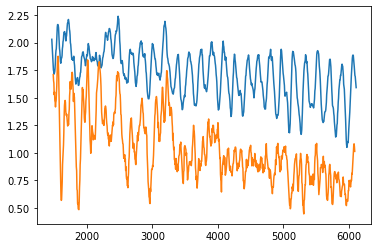

In [14]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# plt.plot(time, ps - np.mean(ps))
plt.plot(A2_time[idx_list], A2[idx_list]*10)
plt.plot(moving_average(time, 10), -moving_average(tz_gas, 10)/10.)
# plt.xlim(0, 1000)a
# plt.plot(time-25, (tz_halo/800 - np.mean(tz_halo/800)))
plt.show()

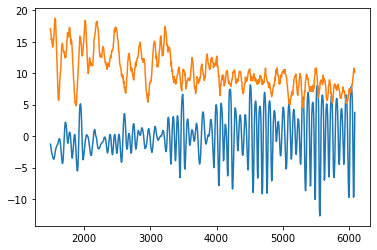

In [15]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

N = 10

plt.plot(moving_average(time, N), moving_average(ps - np.mean(ps), N))
# plt.plot(A2_time[idx_list], A2[idx_list]*10)
plt.plot(moving_average(time, N), -moving_average(tz_gas, N))
# plt.xlim(0, 1000)a
# plt.plot(time-25, (tz_halo/800 - np.mean(tz_halo/800)))
plt.show()

/n/home01/abeane/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


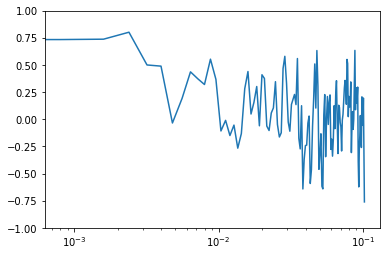

In [16]:
from scipy.signal import csd

t, this_A2 = A2_time[idx_list], A2[idx_list]

fps, Pps = csd(this_A2, this_A2, fs=len(time) / (time[-1] - time[0]))
ftz, Ptz = csd(-tz_gas, -tz_gas, fs=len(time) / (time[-1] - time[0]))
fx, Px = csd(-tz_gas, this_A2, fs=len(time) / (time[-1] - time[0]))

plt.plot(fx, Px/np.sqrt(Pps * Ptz))
plt.xscale('log')
plt.ylim(-1, 1)
plt.show()

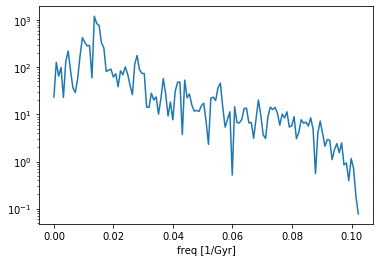

In [25]:
from scipy.signal import csd
fps, Pps = csd(ps, ps, fs=len(time) / (time[-1] - time[0]))
ftz, Ptz = csd(-tz_gas, -tz_gas, fs=len(time) / (time[-1] - time[0]))
fx, Px = csd(-tz_gas, ps, fs=len(time) / (time[-1] - time[0]))

# print(Px)

y = Px/np.sqrt(Pps * Ptz)
# print(np.mean(y))

# plt.plot(fx, Px/np.sqrt(Pps * Ptz))
# plt.xscale('log')
plt.plot(fx, np.abs(Px))
plt.yscale('log')
plt.xlabel('freq [1/Gyr]')
# plt.ylim(-1, 1)
plt.show()

In [29]:
from scipy.signal import csd
fps, Pps = csd(ps, ps, fs=len(time) / (time[-1] - time[0]))
ftz, Ptz = csd(-tz_gas, -tz_gas, fs=len(time) / (time[-1] - time[0]))
fx, Px = csd(-tz_gas, ps, fs=len(time) / (time[-1] - time[0]))

# print(Px)

y = np.correlate(-tz_gas, ps)
z0 = np.correlate(-tz_gas, -tz_gas)
z1 = np.correlate(ps, ps)
# print(np.mean(y))

print(y)
print(z0, z1)
print(y/np.sqrt(z0*z1))

# # plt.plot(fx, Px/np.sqrt(Pps * Ptz))
# # plt.xscale('log')
# plt.plot(fx, np.abs(Px))
# plt.yscale('log')
# plt.xlabel('freq [1/Gyr]')
# # plt.ylim(-1, 1)
# plt.show()

[407017.18675953]
[120831.60982765] [1731656.49880771]
[0.88979835]


In [36]:
r0 = np.random.rand(len(tz_gas))
r1 = np.random.rand(len(tz_gas))

x = np.correlate(r0, r1)
x0 = np.correlate(r0, r0)
x1 = np.correlate(r1, r1)

print(x/np.sqrt(x0*x1))

[0.73544324]


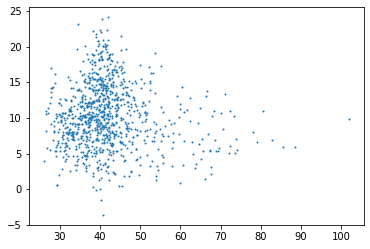

In [40]:
plt.scatter(ps, -tz_gas, s=1)
plt.show()

/n/home01/abeane/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


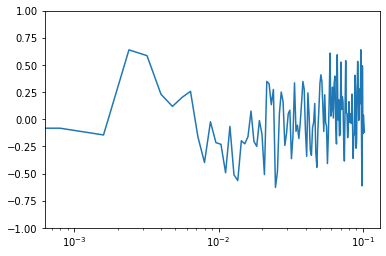

In [18]:
from scipy.signal import csd
fps, Pps = csd(ps, ps, fs=len(time) / (time[-1] - time[0]))
ftz, Ptz = csd(tz_halo, tz_halo, fs=len(time) / (time[-1] - time[0]))
fx, Px = csd(tz_halo, ps, fs=len(time) / (time[-1] - time[0]))

plt.plot(fx, Px/np.sqrt(Pps * Ptz))
plt.xscale('log')
plt.ylim(-1, 1)
plt.show()

In [105]:
def lag_finder(y1, y2, sr, sgn=1):
    n = len(y1)

    corr = signal.correlate(y2, y1, mode='same') / np.sqrt(signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])

    delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
    delay = delay_arr[np.argmax(sgn*corr)]
    print('y2 is ' + str(delay) + ' behind y1')
    print('max corr: ', sgn*np.max(sgn*corr))
    print('corr at ')
    
    plt.figure()
    plt.plot(delay_arr, corr)
    plt.title('Lag: ' + str(np.round(delay, 3)) + ' s')
    plt.xlabel('Lag')
    plt.ylabel('Correlation coeff')
    plt.show()

y2 is 0.15025423728813614 behind y1
max corr:  0.5526069123291791


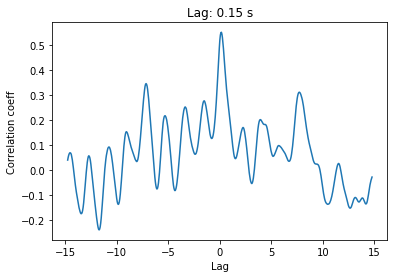

In [106]:
y1 = np.copy(A2[idx_list])
y2 = -np.copy(tz_gas)

# y1 = moving_average(y1, 5)
y1 = y1[4:-5]
y2 = moving_average(y2, 10)

y1 -= np.mean(y1)
y2 -= np.mean(y2)

lag_finder(y1, y2, 20, sgn=1)

y2 is -39.765100671140935 behind y1
max corr:  0.4551233388437327


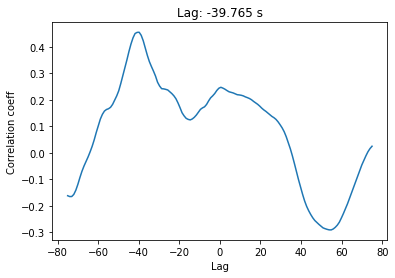

In [43]:
y1 = np.copy(bar_angle - lin_ba)
y2 = np.copy(tz_gas)

y1 -= np.mean(y1)
y2 -= np.mean(y2)

lag_finder(y1, y2, 1, sgn=1)

y2 is 0.42785234899328817 behind y1
max corr:  0.2447805285852913


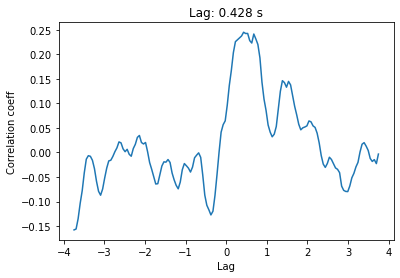

In [46]:
y1 = ps - np.mean(ps)
y2 = tz_halo - np.mean(tz_halo)

lag_finder(y1, y2, 20, sgn=1)

y2 is 0.42785234899328817 behind y1
max corr:  0.2447805285852913


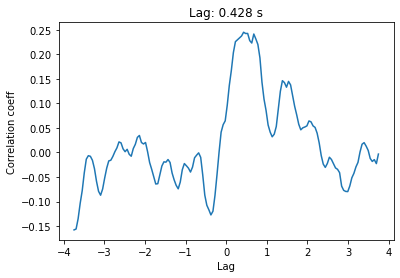

In [49]:
y1 = ps - np.mean(ps)
y2 = tz_halo - np.mean(tz_halo)

lag_finder(y1, y2, 20, sgn=1)

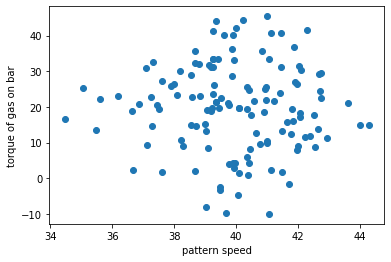

In [50]:
shft=-1
mn = 10
mx = len(ps)-10
plt.scatter((ps)[mn+shft:mx+shft], -tz_gas[mn:mx])
plt.xlabel('pattern speed')
plt.ylabel('torque of gas on bar')
plt.show()

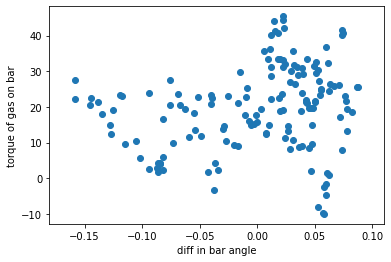

In [51]:
shft=0
mn = 0
mx = len(bar_angle)
plt.scatter((bar_angle - lin_ba)[mn+shft:mx+shft], -tz_gas[mn:mx])
plt.xlabel('diff in bar angle')
plt.ylabel('torque of gas on bar')
plt.show()

In [92]:
from scipy.signal import spectrogram, periodogram, lombscargle, correlate


In [90]:
f_ba, P_ba = periodogram(bar_angle-lin_ba, fs=20.0)
f_ps, P_ps = periodogram(ps, fs=20.0)
f_tz, P_tz = periodogram(tz_gas, fs=20.0)

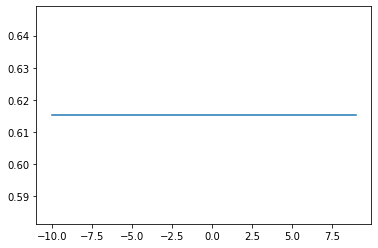

In [108]:
shft=0
mn = 10
mx = len(bar_angle)-10


ccoef = []
for shft in np.arange(-10, 10):
    r = np.corrcoef((tz_gas + tz_halo + tz_not_bar)[mn:mx], (bar_angle-lin_ba)[mn:mx])
    ccoef.append(r[1][0])

plt.plot(np.arange(-10, 10), ccoef)
plt.show()

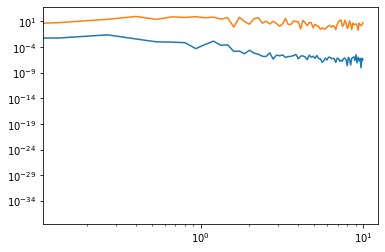

In [91]:
plt.plot(f_ba, P_ba)
plt.plot(f_tz, f_tz * P_tz)
# plt.plot(f_ps, f_ps * P_ps)
plt.yscale('log')
plt.xscale('log')
plt.show()

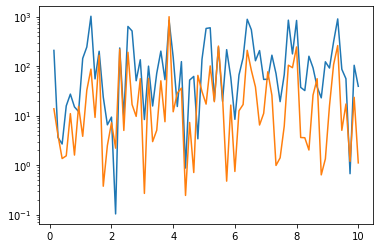

In [87]:
p_tz = lombscargle(time, tz_gas, f_tz[1:])
p_ba = lombscargle(time, bar_angle, f_ba[1:])
plt.plot(f_tz[1:], p_tz)
plt.plot(f_tz[1:], p_ba)
plt.yscale('log')
# plt.xscale('log')
plt.show()

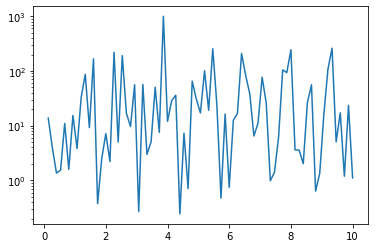

In [88]:
p = lombscargle(time, bar_angle, f_ba[1:])
plt.plot(f_ba[1:], p)
plt.yscale('log')
# plt.xscale('log')
plt.show()

In [89]:
plt.pcolormesh(t_tz, f_tz, S_tz, shading='gouraud')
plt.ylim(0, 2)
plt.show()

NameError: name 't_tz' is not defined

In [152]:
S_ba

array([[7.36253950e-03, 8.49081031e-04, 1.30131458e-03, 2.35543482e-04,
        2.86781394e-06],
       [5.93499111e+00, 1.82401769e-01, 2.07400812e-01, 7.69957412e-01,
        1.41635474e+00],
       [7.35714762e-01, 6.95571112e-02, 3.90642988e-02, 1.14022518e-01,
        2.04813243e-01],
       [1.18266925e-01, 1.21005665e-02, 4.32807197e-03, 1.47742173e-02,
        2.83420270e-02],
       [5.93080013e-03, 1.74438536e-03, 1.00528897e-03, 8.12600996e-04,
        5.84575602e-04],
       [8.99256944e-03, 2.30142147e-03, 4.28568758e-04, 1.28144208e-03,
        3.03307036e-03],
       [1.64504208e-02, 1.14591813e-04, 1.87536571e-03, 1.80930740e-03,
        4.35440575e-03],
       [1.47613154e-02, 2.36016188e-03, 2.17254037e-03, 8.71998626e-04,
        1.00204534e-03],
       [4.82042272e-03, 4.62162217e-04, 4.96065638e-04, 2.31187925e-03,
        1.61497067e-03],
       [1.78855799e-03, 6.90733891e-06, 5.12321730e-05, 2.26020380e-03,
        9.10802544e-04],
       [7.63106031e-04, 1.9481

In [103]:
f, t, S = spectrogram(-tz_gas)

/n/home01/abeane/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  .format(nperseg, input_length))


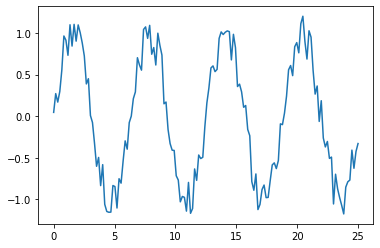

In [129]:
x = np.linspace(0, 25, 150)
y = np.sin(x) + 0.5 *( np.random.rand(150) - 0.5)

plt.plot(x, y)
plt.show()

In [130]:
f, t, S = spectrogram(y, 1./(x[1]-x[0]))

/n/home01/abeane/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 150, using nperseg = 150
  .format(nperseg, input_length))


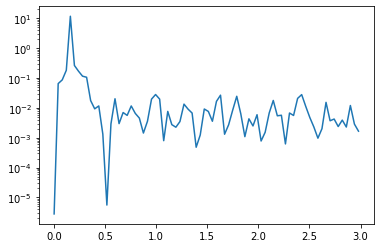

In [132]:
plt.plot(f, S)
plt.yscale('log')
plt.show()